# photometry_single.ipynb

Visitごとに、セレクトされたデータを用いて開口測光を行い、スポットの位置(緯度・経度)や明るさ(EFPの明るさとバックグラウンド)を測定し保存する。

In [21]:
import numpy as np
import math
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from numba import njit
import os
import pandas as pd

import spiceypy as spice
import hstprojimage as hst
from TScmap import TScmap

fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                    'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })

spice.furnsh('kernel/cassMetaK.txt')

# cpalette = ['#8ecae6', '#ffb703', '#023047', '#fb8500', '#219ebc']
cpalette = ['#0F4C81', '#FF6F61', '#645394',
         '#84BD00', '#F6BE00', '#F7CAC9', '#0F80E6']

In [22]:
# Model positions
SATELLITE = ['EU']              # 'AM', 'IO', 'EU', 'GA'
model_fpN= np.loadtxt('data/JRM33/2021je007055-sup-0003-table si-s02.txt', skiprows=3)
model_fpN = np.vstack((model_fpN, model_fpN[0:2,:]))
model_fpS = np.loadtxt('data/JRM33/2021je007055-sup-0004-table si-s03.txt', skiprows=3)
model_fpS = np.vstack((model_fpS, model_fpS[0:2,:]))
satellite_name = ['AM', 'IO', 'EU', 'GA']          # 'AM', 'IO', 'EU', 'GA'
satellite_color = ['#888888', '#000000', '#f24875', '#888888']
satellite_marker = ['o', '*', 's', 'd']
satellite_index = [satellite_name.index(i) for i in (SATELLITE)]

### Functions

In [23]:
def dataload(filename, extdeg):
    """ Description

    Args:
        filename (str): fits file
        extdeg (float): extent of the image [deg]

    Returns:
        h (class): 
        dimage (np.array): polar projected image
    """

    ext = 0
    hext = 1
    with fits.open(filename) as hdul:
        image = hdul[ext].data      # .astype(np.float32)
        h = hdul[hext].header

    h = hst.HSTProjImage(filename)
    h.readHSTFile()
    h.MOON = 'EUROPA'
    hem = h.alm.hemisph
    print('hem', hem)

    fig, ax = plt.subplots(dpi=200)
    ax, dimage, gl = h.tvPolar(ax, vmin=10, vmax=2000,
                    draw_labels=False, refmainoval=False,
                    satovals=['eu'],
                    reflon=None,
                    # reflon=h.alm.cml,
                    ext=extdeg,
                    )
    plt.close()
    return h, dimage

In [24]:
def lat_wlong2px(lat, wlong, N0px, extdeg, hem):
    """_summary_

    Args:
        lat (float): latitude of the point [deg]
        wlong (float): west longitude of the point [deg]
        N0px (int): number of pixels in an axis [px]
        extdeg (float): extent of the image [deg]

    Returns:
        X: X position [px]
        Y: Y position [px]
    """
    if hem=='south':
        lat = lat * (-1)

    elon = 360-(wlong-90)        # [deg]
    colat = 90-lat               # [deg]
    R = (N0px/2)*(np.tan(np.radians(colat/2))/np.tan(np.radians((90-extdeg)/2)))     # [px]
    X = R*np.cos(np.radians(elon))         # [px]
    Y = R*np.sin(np.radians(elon))         # [px]
    X += N0px/2
    Y += N0px/2
    return X, Y

In [25]:
def px2lat_wlong(X, Y, N0px, extdeg, hem):
    """_summary_

    Args:
        X (float): X position(s) [px]
        Y (float): Y position(s) [px]
        N0px (int): number of pixels in an axis [px]
        extdeg (float): extent of the image [deg]

    Returns:
        lat: latitude [deg]
        wlong: west longitude [deg]
    """
    posX = X-N0px/2
    posY = Y-N0px/2

    posR = np.sqrt(posX**2 + posY**2)
    poscolat = np.degrees(2*np.arctan2(posR*np.tan(0.5*np.radians(90-extdeg)), N0px/2))
    postheta = np.arctan2(posY,posX)-0.5*np.pi

    wlong = -np.degrees(postheta)
    lat =  90-poscolat

    if hem=='south':
        lat = lat*(-1)

    return lat, wlong

In [26]:
def Aperture(IMAGE, POSITION, VMODEL, NPX):
    """_summary_

    Args:
        IMAGE (2d ndarray): raw image
        POSITION (1d array): position of one spot in the raw image
        VMODEL (1d array): Vector that connects the two model footprints (the best and the 2nd best)
        NPX (int): X size of the image

    Returns:
        apertures (CircularAperture): \n
        rawflux (QTable): QTable including the spot position and the final photometry averaged in pixels. \n
            `['id']` \n
            `['xcenter']` : x position [px] \n
            `['ycenter']` : y position [px] \n
            `['aperture_sum']` : summation of brightness in the target aperture
            `['annulus_median']` : the median inside the donut \n
            `['aper_bkg']` : summation of the median inside the donut \n
            `['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']` \n
            `['final_phot_ave'] = rawflux['final_phot']/apertures.area`
            
    """
    # Make a mask
    r_in = 6        # [px]
    r_out = 12      # [px]
    xgrid = np.arange(-r_out, r_out+1, 1)
    ygrid = np.arange(-r_out, r_out+1, 1)
    xgrid, ygrid = np.meshgrid(xgrid, ygrid)
    rgrid = np.sqrt(xgrid**2 + ygrid**2)
    mask_arr = np.zeros(xgrid.shape)
    ring = np.where((rgrid>r_in)&(rgrid<=r_out))
    mask_arr[ring] = 1

    # Calculate the dot
    dot = VMODEL[0]*xgrid + VMODEL[1]*ygrid
    dotmask = np.where((mask_arr>0)&(dot<0))
    mask_arr[dotmask] = 2
    mask_arr[np.where(mask_arr<2)] = 0
    mask_arr[np.where(mask_arr>0)] = 1

    # Mask
    mask = np.zeros((NPX, NPX))
    bposx = POSITION[0]
    bposy = POSITION[1]
    mask[int(bposy)-r_out:int(bposy)+r_out+1, int(bposx)-r_out:int(bposx)+r_out+1] = mask_arr

    # Masked standard deviation
    maskedimg = mask*IMAGE
    _, median_sigclip, _ = sigma_clipped_stats(maskedimg[np.where(maskedimg>0)])
    bkg_median = median_sigclip*1.0

    # Aperture photometry
    apertures = CircularAperture(POSITION, r=4.)
    rawflux = aperture_photometry(IMAGE, apertures)

    """
    # Make a donut to calculate the local background in.
    annulus_apertures = CircularAnnulus(POSITION, r_in=5.5, r_out=9.)

    # Sigma-clipping
    # http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
    annulus_masks = annulus_apertures.to_mask(method='center')

    # Mask inside the donut
    annulus_data = annulus_masks.multiply(IMAGE)
    annulus_data_1d = annulus_data[annulus_masks.data > 0]  # 輪っか内部の値だけ抽出

    # Calculate the median as the local background
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median = median_sigclip*1.0   
    """

    # Add results to the rawflux data
    rawflux['annulus_median'] = bkg_median
    rawflux['aper_bkg'] = bkg_median*apertures.area
    rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
    rawflux['final_phot_ave'] = rawflux['final_phot']/apertures.area
    
    return apertures, rawflux

### Code

In [27]:
extdeg = 45.0
year = '2014'
yearlydata_dir = 'data/red3/EUROPA/'+year

doy_visit_list = sorted(os.listdir(yearlydata_dir))
print(doy_visit_list)

['006_v06', '013_v13', '016_v12']


data/red3/EUROPA/2014/006_v06/jup_14-006-02-35-18_0030_v06_stis_f25srf2_flatproj.fits
OBS DATE 2014-01-06T02:35:18
hem north
=== JRM33 Estimation ===
Wlong [deg] 152.62117521949583
Lat [deg] 52.78842080905891


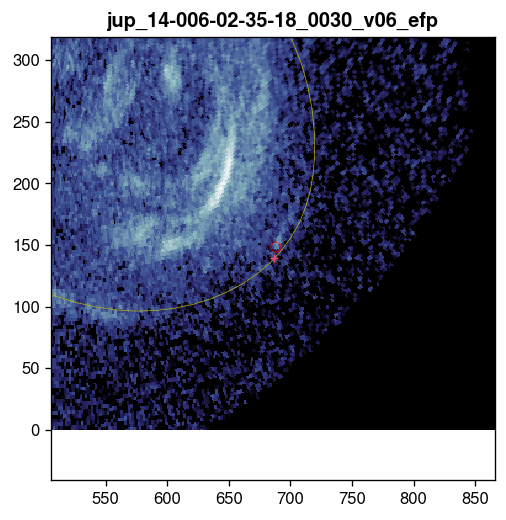

=== The spot ===
Nearest Pixel ID and position [px]: 2 [658.15733014 149.50590787]
Number of pixels [px]:  25
Brightness ave [kR]:  127.97097502472036
Brightness bkg [kR]:  62.096473693847656
Wlong [deg] 151.84772998322958
Lat [deg] 53.42434632777996


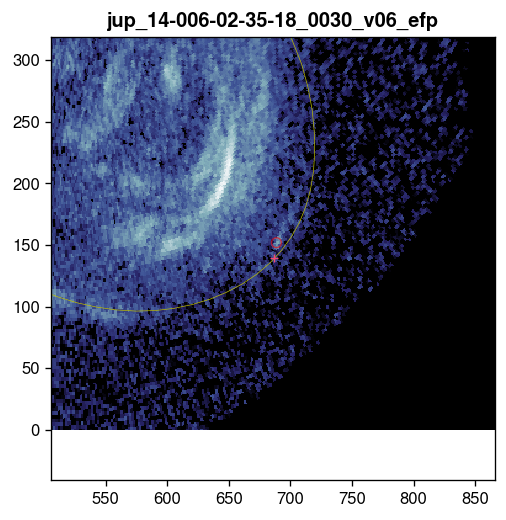

=== The spot ===
Nearest Pixel ID and position [px]: 5 [607.31568875 154.06367196]
Number of pixels [px]:  25
Brightness ave [kR]:  179.32662533708105
Brightness bkg [kR]:  60.07452392578125
Wlong [deg] 151.54601651574762
Lat [deg] 53.68228541345377


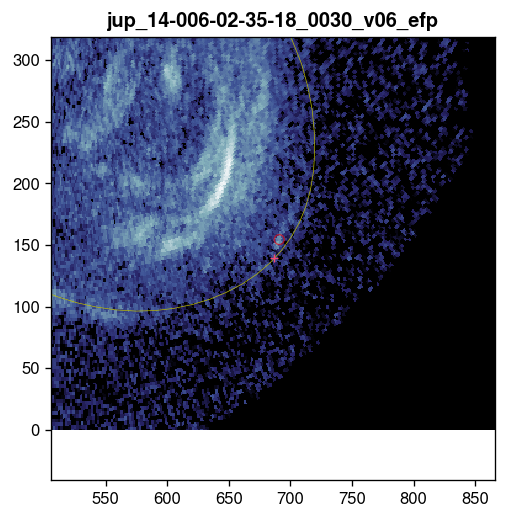

=== The spot ===
Nearest Pixel ID and position [px]: 8 [621.91171361 158.22297747]
Number of pixels [px]:  25
Brightness ave [kR]:  157.55945821786523
Brightness bkg [kR]:  58.09158706665039
Wlong [deg] 151.07945651314043
Lat [deg] 53.77534203616532


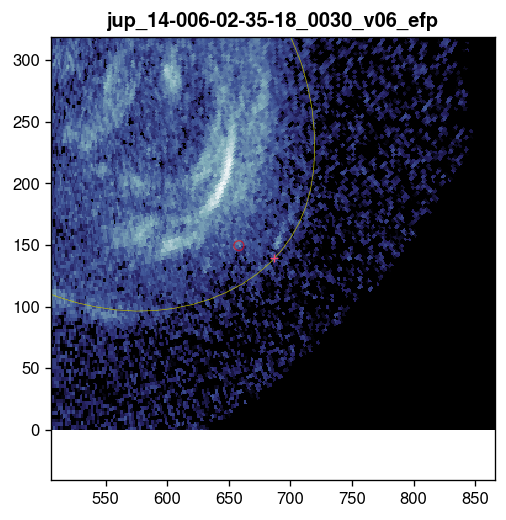

=== The spot ===
Nearest Pixel ID and position [px]: 2 [617.11189173 151.05405692]
Number of pixels [px]:  25
Brightness ave [kR]:  82.61588963316021
Brightness bkg [kR]:  108.55193710327148
Wlong [deg] 155.7131484881726
Lat [deg] 54.66130405840606
data/red3/EUROPA/2014/006_v06/jup_14-006-02-35-28_0030_v06_stis_f25srf2_flatproj.fits
OBS DATE 2014-01-06T02:35:28
hem north
=== JRM33 Estimation ===
Wlong [deg] 152.6533522305718
Lat [deg] 52.781487640926514


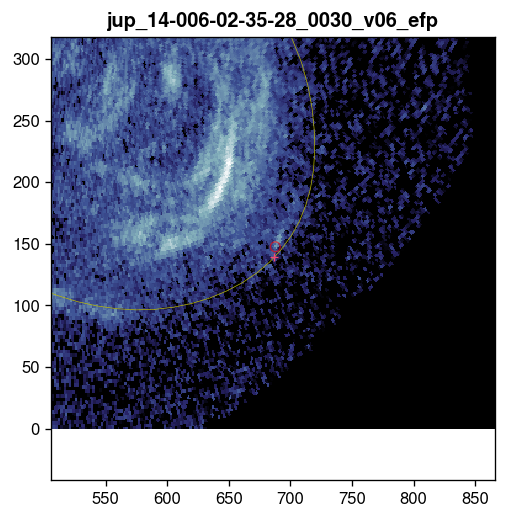

=== The spot ===
Nearest Pixel ID and position [px]: 1 [643.97093156 149.18123354]
Number of pixels [px]:  25
Brightness ave [kR]:  130.75025987207388
Brightness bkg [kR]:  58.805227279663086
Wlong [deg] 151.95477629758457
Lat [deg] 53.39191085269479


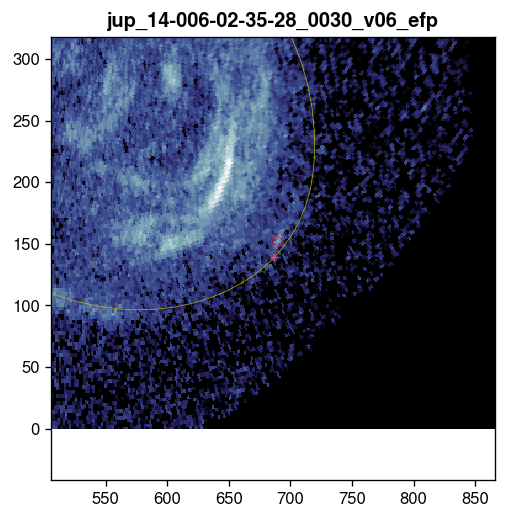

=== The spot ===
Nearest Pixel ID and position [px]: 3 [621.68605151 153.68325985]
Number of pixels [px]:  25
Brightness ave [kR]:  171.73951702335148
Brightness bkg [kR]:  80.09667205810547
Wlong [deg] 151.49323528066293
Lat [deg] 53.67590596614006


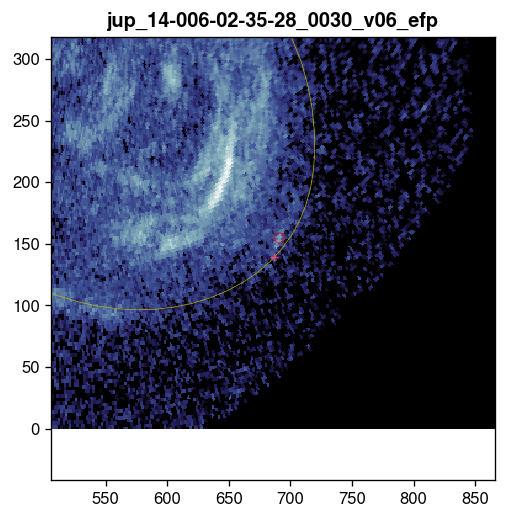

=== The spot ===
Nearest Pixel ID and position [px]: 4 [607.36093369 156.9568358 ]
Number of pixels [px]:  25
Brightness ave [kR]:  148.70503043087882
Brightness bkg [kR]:  94.2599105834961
Wlong [deg] 151.07077068693602
Lat [deg] 53.8121753469389


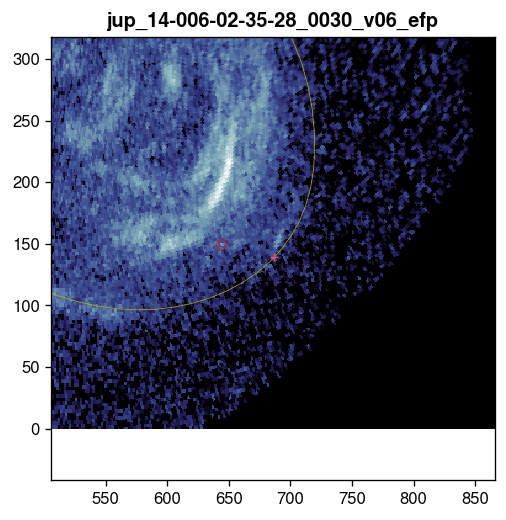

=== The spot ===
Nearest Pixel ID and position [px]: 1 [617.64706091 152.00564128]
Number of pixels [px]:  25
Brightness ave [kR]:  60.9867185384735
Brightness bkg [kR]:  113.18817138671875
Wlong [deg] 157.68746493292392
Lat [deg] 55.11986355143484
data/red3/EUROPA/2014/006_v06/jup_14-006-02-35-38_0030_v06_stis_f25srf2_flatproj.fits
OBS DATE 2014-01-06T02:35:38
hem north
=== JRM33 Estimation ===
Wlong [deg] 152.68552923643105
Lat [deg] 52.77455447391817


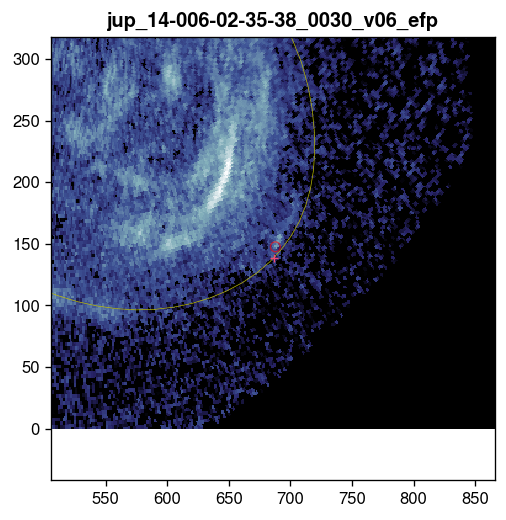

=== The spot ===
Nearest Pixel ID and position [px]: 3 [608.58940719 149.62317625]
Number of pixels [px]:  25
Brightness ave [kR]:  156.41014126364024
Brightness bkg [kR]:  50.242774963378906
Wlong [deg] 151.95101366819955
Lat [deg] 53.38773055407521


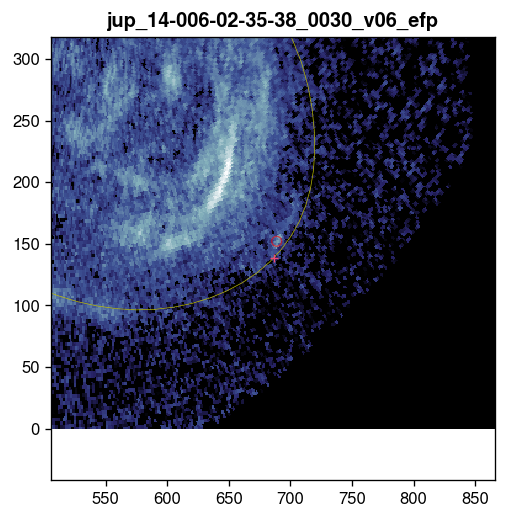

=== The spot ===
Nearest Pixel ID and position [px]: 5 [620.70853845 153.10471068]
Number of pixels [px]:  25
Brightness ave [kR]:  179.65340521845957
Brightness bkg [kR]:  73.64818572998047
Wlong [deg] 151.51455132954064
Lat [deg] 53.68355174066265


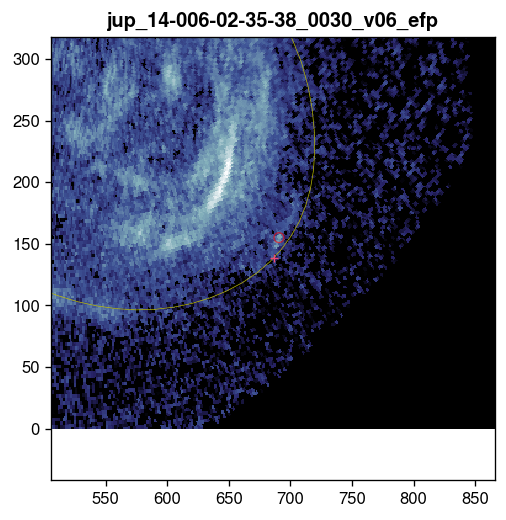

=== The spot ===
Nearest Pixel ID and position [px]: 10 [650.14549671 167.3294123 ]
Number of pixels [px]:  25
Brightness ave [kR]:  168.6555486738469
Brightness bkg [kR]:  73.83833312988281
Wlong [deg] 151.07152794081577
Lat [deg] 53.830153289201284
data/red3/EUROPA/2014/006_v06/jup_14-006-02-35-48_0030_v06_stis_f25srf2_flatproj.fits
OBS DATE 2014-01-06T02:35:48
hem north
=== JRM33 Estimation ===
Wlong [deg] 152.7177062371012
Lat [deg] 52.76762130802792


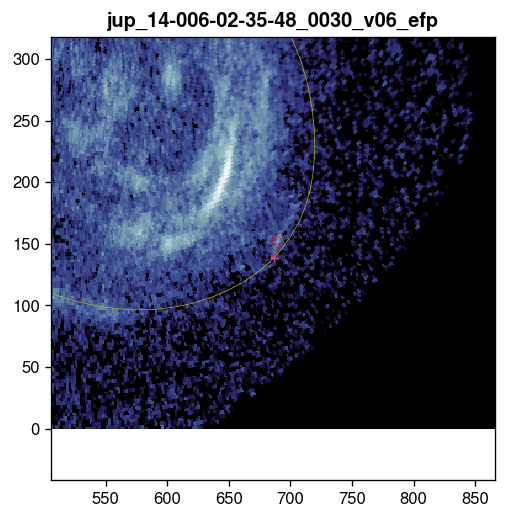

=== The spot ===
Nearest Pixel ID and position [px]: 5 [614.34849426 153.50965728]
Number of pixels [px]:  25
Brightness ave [kR]:  172.74207828350967
Brightness bkg [kR]:  68.0167236328125
Wlong [deg] 151.51784000180768
Lat [deg] 53.66684782708803


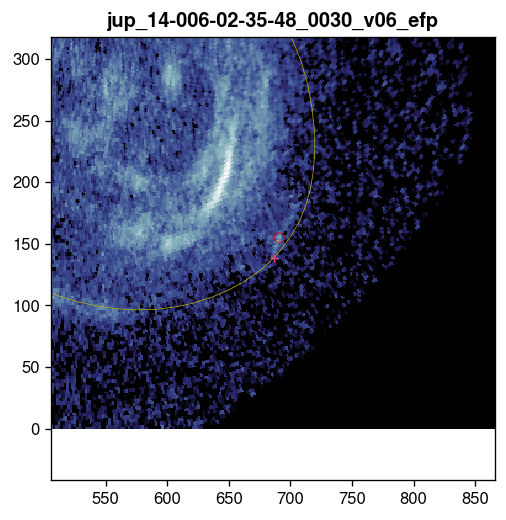

=== The spot ===
Nearest Pixel ID and position [px]: 8 [615.48027457 155.87456404]
Number of pixels [px]:  25
Brightness ave [kR]:  125.9040222682495
Brightness bkg [kR]:  90.54157257080078
Wlong [deg] 151.06689894723775
Lat [deg] 53.824051855596636


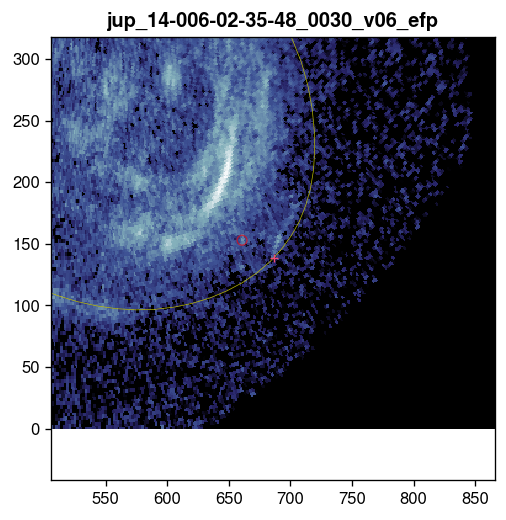

=== The spot ===
Nearest Pixel ID and position [px]: 6 [607.34026227 154.03532896]
Number of pixels [px]:  25
Brightness ave [kR]:  81.95597995966924
Brightness bkg [kR]:  101.52415466308594
Wlong [deg] 155.15273512650015
Lat [deg] 54.83247499362831
data/red3/EUROPA/2014/006_v06/jup_14-006-02-35-58_0030_v06_stis_f25srf2_flatproj.fits
OBS DATE 2014-01-06T02:35:58
hem north
=== JRM33 Estimation ===
Wlong [deg] 152.74988323228246
Lat [deg] 52.76068814332036


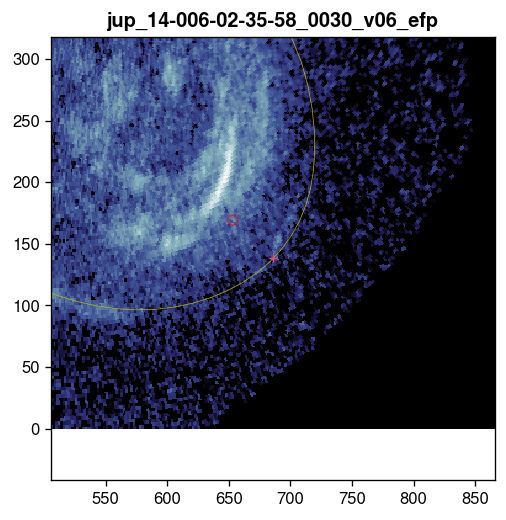

=== The spot ===
Nearest Pixel ID and position [px]: 7 [619.97392744 170.26974283]
Number of pixels [px]:  25
Brightness ave [kR]:  45.61101505984743
Brightness bkg [kR]:  161.8983917236328
Wlong [deg] 155.14818364440742
Lat [deg] 56.38836934159673
data/red3/EUROPA/2014/006_v06/jup_14-006-02-36-08_0030_v06_stis_f25srf2_flatproj.fits
OBS DATE 2014-01-06T02:36:08
hem north
=== JRM33 Estimation ===
Wlong [deg] 152.78206022283106
Lat [deg] 52.75375497961099


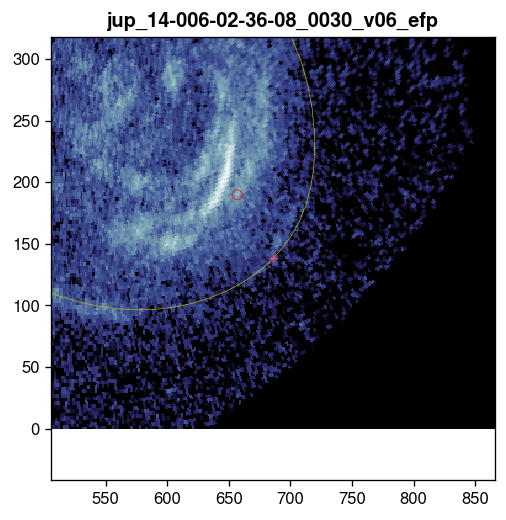

=== The spot ===
Nearest Pixel ID and position [px]: 13 [640.56523534 190.70887979]
Number of pixels [px]:  25
Brightness ave [kR]:  120.59091204846683
Brightness bkg [kR]:  323.830810546875
Wlong [deg] 153.1801914252407
Lat [deg] 57.871566887796895
data/red3/EUROPA/2014/006_v06/jup_14-006-02-36-18_0030_v06_stis_f25srf2_flatproj.fits
OBS DATE 2014-01-06T02:36:18
hem north
=== JRM33 Estimation ===
Wlong [deg] 152.81423720847278
Lat [deg] 52.74682181695891


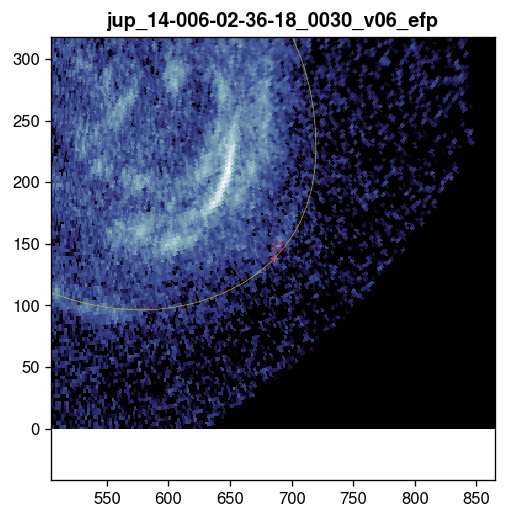

=== The spot ===
Nearest Pixel ID and position [px]: 4 [605.6817411  150.66836463]
Number of pixels [px]:  25
Brightness ave [kR]:  104.8199422361096
Brightness bkg [kR]:  55.688180923461914
Wlong [deg] 151.75432006313855
Lat [deg] 53.34103360385531


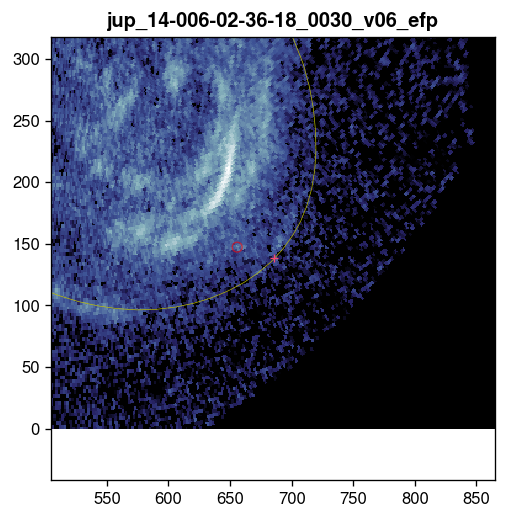

=== The spot ===
Nearest Pixel ID and position [px]: 3 [605.6817411  150.66836463]
Number of pixels [px]:  25
Brightness ave [kR]:  78.58391949669588
Brightness bkg [kR]:  109.89725494384766
Wlong [deg] 156.1691002835829
Lat [deg] 54.56955618651772


In [28]:
for doyvisit in doy_visit_list[0:1]:
    fits30s = sorted(os.listdir(yearlydata_dir+'/'+doyvisit))
    
    savedir = 'img/red3_half2/'+'EUROPA'+'/'+year+'/'+doyvisit
    brightnessCSV = ['date', 'lat [deg]', 'wlong [deg]', 'Moon S3 [deg]', 'spot brightness [kR]', 'local background [kR]']
    brightlist = np.zeros((len(fits30s), 5)).tolist()
    
    try:
        os.makedirs(savedir)
    except FileExistsError:
        savedir += '_R'
        os.makedirs(savedir)

    for j in range(len(fits30s)):
        dataname = yearlydata_dir+'/'+doyvisit+'/'+fits30s[j]
        print(dataname)
        h, dimage = dataload(dataname, extdeg)
        hem = h.alm.hemisph

        Npx = dimage.shape[0]
        dimage = dimage[:,::-1]
        if hem == 'south':
            dimage = dimage[:,::-1]

        # JRM33 Estimation of EFP
        print('=== JRM33 Estimation ===')
        print('Wlong [deg]', h.s3wlon_lin)
        print('Lat [deg]', h.s3lat_lin)
        ftpX, ftpY = lat_wlong2px(h.s3lat_lin, h.s3wlon_lin, Npx, extdeg, hem)    # footprint best fit
        ftpX0, ftpY0 = lat_wlong2px(h.s3lat00, h.s3wlon00, Npx, extdeg, hem)      # footprint 2nd best
        # print(ftpcolat, ftpR, ftpX, ftpY)

        # Vector that connects the two model footprints
        # vmodel = np.array([ftpX0-ftpX, ftpY0-ftpY])
        if h.s3wlon00 < h.s3wlon_lin:
            vmodel = np.array([ftpX0-ftpX, ftpY0-ftpY])
        else:
            vmodel = np.array([ftpX-ftpX0, ftpY-ftpY0])

        # Trim the image
        x0, x1 = int(ftpX-80), int(ftpX+80)           # [px]
        y0, y1 = int(ftpY-80), int(ftpY+80)           # [px]
        # print('x0,x1,y0,y1', x0,x1,y0,y1)
        img = dimage[y0:y1,x0:x1]
        # fig, ax = plt.subplots(dpi=100)
        # ax.pcolormesh(img)
        # plt.show()
        
        # Stats
        mean = np.average(img)
        median = np.median(img)
        std = np.std(img)
        thres = 1.0*std
        daofind = DAOStarFinder(fwhm=2.0, threshold=thres)  
        # https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html
        # DAOStarFinderのfluxの定義 ... stdのfactor倍
        sources = daofind(img)  

        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  # [px]
        positions[:,0] += x0    # [px]
        positions[:,1] += y0    # [px]

        YN = 'n'
        while YN == 'n':
            posarg0 = np.argmin(np.absolute((positions[:,0]-ftpX)**2 + (positions[:,1]-ftpY)**2))

            poslat, poswlong = px2lat_wlong(positions[posarg0,0], positions[posarg0,1], Npx, extdeg, hem)

            title, _ = fits30s[j].split('_stis_')
            title = title+'_efp'
            # Plot
            fig, ax = plt.subplots(dpi=120)
            ax.set_title(title, weight='bold')
            ax.set_aspect('equal')
            ax.set_xlim(x0-100, x1+100)
            ax.set_ylim(y0-100, y1+100)
            ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
                        norm=colors.LogNorm(vmin=10, vmax=2000),
                        zorder=0.1)
            ax.plot(ftpX, ftpY,
                    markersize=5, marker='+', markerfacecolor='#f24875',
                    markeredgecolor='#f24875', markeredgewidth=0.8, zorder=1)
            # apertures = CircularAperture(positions[posarg0,:], r=4.)
            # apertures.plot(color='red', lw=1.0, alpha=0.6)
            aper, rawflux = Aperture(dimage, positions[posarg0,:], vmodel, Npx)
            aper.plot(color='red', lw=0.8, alpha=0.6)

            # Model positions
            if hem=='north':
                model_fp = model_fpN
            else:
                model_fp = model_fpS
            for i in satellite_index:
                latidx = 2*i+1
                s3idx = latidx+1
                mfpX, mfpY = lat_wlong2px(model_fp[:-1, latidx], model_fp[:-1, s3idx], Npx, extdeg, hem)
                ax.plot(mfpX, mfpY, 'y', lw=0.4, zorder=0.5)
                plt.show()

            TFindex = np.ones(positions.shape[0], dtype=bool)
            TFindex[posarg0] = False
            positions = positions[TFindex]

            print('=== The spot ===')
            print('Nearest Pixel ID and position [px]:', posarg0, positions[posarg0,:])
            print('Number of pixels [px]: ', sources['npix'][posarg0])
            print('Brightness ave [kR]: ', rawflux['final_phot_ave'][0])
            print('Brightness bkg [kR]: ', rawflux['annulus_median'][0])
            print('Wlong [deg]', poswlong)
            print('Lat [deg]', poslat)

            YN = input('Yes or No or ZERO? (y/n/0/end)')


        brightlist[j] = [h.datetime, poslat, poswlong, h.s3moon, rawflux['final_phot_ave'][0], rawflux['annulus_median'][0]]

        # fig.savefig(savedir+'/'+title+'.jpg')

        if YN=='0':
            brightlist[j] = [h.datetime, 0, 0, h.s3moon, 0, 0]
        
        if YN=='end':
            break
    
    
    # df = pd.DataFrame(brightlist)
    # df.to_csv(savedir+'/brightness.csv', header=brightnessCSV, sep='\t')